In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import FeatureAblation

%matplotlib inline

In [2]:
model = torch.load('weights/classifier.pth')
model.eval()
torch.manual_seed(123)
np.random.seed(123)

In [3]:
transform = transforms.Compose([
 transforms.Resize((256, 256)),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('data/train_images/0a1b596.jpg')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0).to('cuda:0')
output = model(input)

In [4]:
idx_to_labels = ['flower', 'gravel', 'sugar', 'fish']
output = F.softmax(output, dim=1)

In [5]:
df = pd.read_csv('data/train.csv')

df['image'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
df['label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])


df[df['image'] == '0a1b596.jpg']

,Image_Label,EncodedPixels,image,label
820,0a1b596.jpg_Fish,NaN,0a1b596.jpg,Fish
821,0a1b596.jpg_Flower,NaN,0a1b596.jpg,Flower
822,0a1b596.jpg_Gravel,528792 399 530192 399 531592 399 532992 399 53...,0a1b596.jpg,Gravel
823,0a1b596.jpg_Sugar,1022510 319 1023910 319 1025310 319 1026710 31...,0a1b596.jpg,Sugar


In [20]:
def rle_to_mask(rle_string, width = 2100, height = 1400):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype= bool)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [56]:
def get_occlusions_integrated_gradients(img, encoded_pixel, class_label):
    mask = np.array((rle_to_mask(encoded_pixel, 2100, 1400) * 1)).T
    mask = np.where(mask > 0, 1, 0)
    lbl = label(mask)
    props = regionprops(lbl)
    props_list = [prop for prop in props if prop.area > 60000]
    integrated_gradients = IntegratedGradients(model)
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input,
                                           strides = (3, 15, 15),
                                           target=['flower', 'gravel', 'sugar', 'fish'].index(class_label),
                                           sliding_window_shapes=(3,15, 15),
                                           baselines=0)
    attributions_ig = integrated_gradients.attribute(input, target=['flower', 'gravel', 'sugar', 'fish'].index(class_label), n_steps=5)
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    fig, axs = plt.subplots(1,figsize=(15,15), ncols = 3)
    fig, axs[0] = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1, 
                                 plt_fig_axis = (fig, axs[0]), 
                                 use_pyplot = False)
    fig, axs[1] = viz.visualize_image_attr(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1, 
                                 plt_fig_axis = (fig, axs[1]), 
                                 use_pyplot = False)
    axs[2].imshow(transformed_img.detach().cpu().numpy().transpose((1, 2, 0)))
    scale = np.flipud(np.divide((256, 256), (1400, 2100)))
    colors = ['blue','blue','white']
    for ax_idx, ax in enumerate(axs):
        for prop in props_list:
            ax.add_patch(mpl.patches.Rectangle((prop.bbox[0] * scale[0], prop.bbox[1] * scale[1]),
                                               prop.bbox[2] * scale[0] - prop.bbox[0] * scale[0],
                                               prop.bbox[3] * scale[1] - prop.bbox[1] * scale[1],
                                               linewidth= 3,
                                               edgecolor= colors[ax_idx],
                                               facecolor='none'))
    
    axs[0].set_title(f'Integrated Gradients Sensitivity Map, ({class_label})')
    axs[1].set_title(f'Occlusion, ({class_label})')
    axs[2].set_title(f'Original Image, ({class_label})')
    plt.show()

Predicted: sugar :( 0.30418381094932556 )


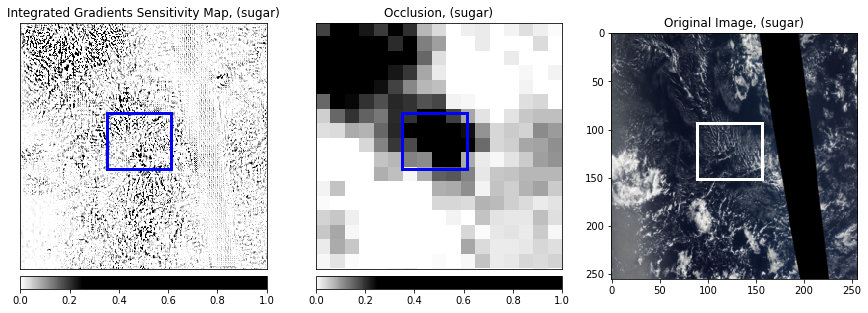

In [57]:
label1 = 'sugar'
prediction_score, pred_label_idx = torch.topk(output, 4)
pred_label_idx.squeeze_()
print('Predicted:', label1, ':(', prediction_score.squeeze()[pred_label_idx.tolist().index(['flower', 'gravel', 'sugar', 'fish'].index(label1))].item(), ')')
encoded_pixel_sugar = df[(df['image'] == '0a1b596.jpg') & (df['label'] == label1.capitalize())]['EncodedPixels'].values[0]
get_occlusions_integrated_gradients(img, encoded_pixel_sugar, label1)

Predicted: gravel :( 0.2569848597049713 )


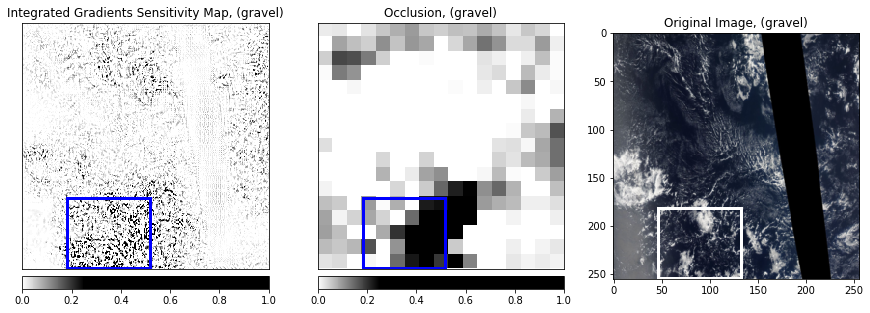

In [58]:
label1 = 'gravel'
prediction_score, pred_label_idx = torch.topk(output, 4)
pred_label_idx.squeeze_()
print('Predicted:', label1, ':(', prediction_score.squeeze()[pred_label_idx.tolist().index(['flower', 'gravel', 'sugar', 'fish'].index(label1))].item(), ')')
encoded_pixel_sugar = df[(df['image'] == '0a1b596.jpg') & (df['label'] == label1.capitalize())]['EncodedPixels'].values[0]
get_occlusions_integrated_gradients(img, encoded_pixel_sugar, label1)